In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['plates.zip', 'sample_submission.csv']
After zip extraction:
['train', '.ipynb_checkpoints', 'submission.csv', 'test', '__MACOSX', 'val', 'plates', '__notebook_source__.ipynb']


In [ ]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['train', 'test', '.DS_Store']


In [ ]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 3338.40it/s]


In [ ]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
from torchvision import transforms, models

## Аугментация

обрезаем по центру, горизонтальные/вертикальные флипы, случайные перестановки каналов

размножение входные данных, так как их очень мало

In [ ]:
train_transforms = transforms.Compose([
     transforms.RandomApply([
        transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue= (0.1, 0.2)
        )
    ]),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(), #p=0.5
    transforms.RandomVerticalFlip(), #p=0.5
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Lambda(
        lambda x: x[np.random.permutation(3), :, :]) #random channerl permutation
])

val_transforms = transforms.Compose([
    transforms.CenterCrop(224),#same as in train
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torch.utils.data.ConcatDataset([
    torchvision.datasets.ImageFolder(train_dir, train_transforms),
    torchvision.datasets.ImageFolder(train_dir, train_transforms),
    torchvision.datasets.ImageFolder(train_dir, train_transforms),
    torchvision.datasets.ImageFolder(train_dir, train_transforms),
    torchvision.datasets.ImageFolder(train_dir, train_transforms),
    torchvision.datasets.ImageFolder(train_dir, train_transforms),
    torchvision.datasets.ImageFolder(train_dir, train_transforms),    
    torchvision.datasets.ImageFolder(train_dir, train_transforms),
    torchvision.datasets.ImageFolder(train_dir, train_transforms),
    torchvision.datasets.ImageFolder(train_dir, train_transforms)
])
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [ ]:
len(train_dataloader), len(train_dataset)

(40, 320)

## Simple visualization

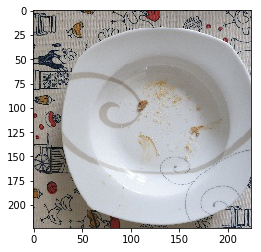

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

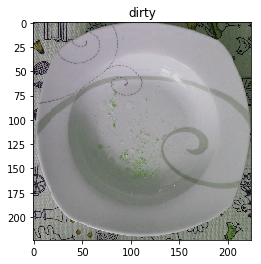

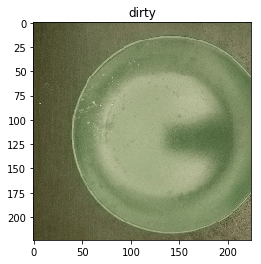

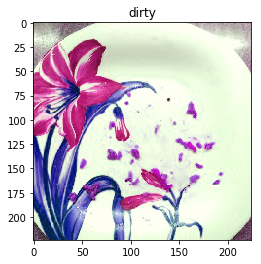

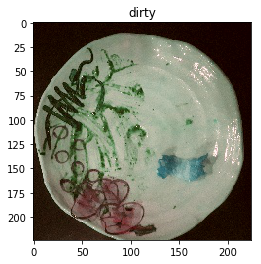

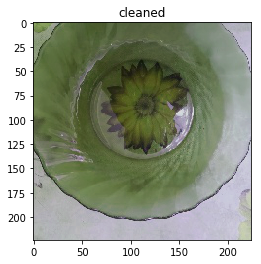

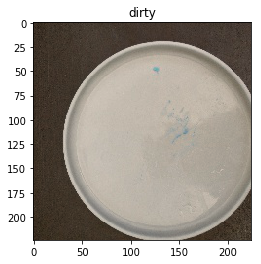

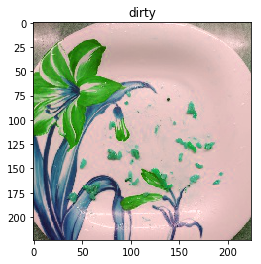

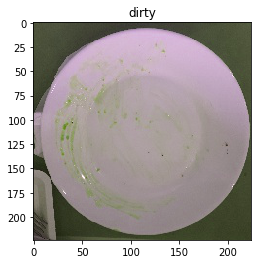

In [ ]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

## Train algorithm

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    
    train_loss_row = []
    train_acc_row = []
    val_loss_row = []
    val_acc_row = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # В торч нужно переключать модели, инче обновляются коэффициенты
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  
            else:
                dataloader = val_dataloader
                model.eval() 

            running_loss = 0.
            running_acc = 0.

            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
        
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            
            if phase == 'train':
                train_loss_row.append(epoch_loss)
                train_acc_row.append(epoch_acc)
            else:
                val_loss_row.append(epoch_loss)
                val_acc_row.append(epoch_acc)

    return model, train_loss_row, train_acc_row, val_loss_row, val_acc_row

## Own class for network


In [ ]:
class PlatesNet(torch.nn.Module):
    def __init__(self):
        super(PlatesNet, self).__init__()
        self.resnet = models.resnet152(pretrained=True, progress=False)

        # Можно выключить градиент, но я не стал
        #for param in self.resnet.parameters():
        #    param.requires_grad = False

        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, self.resnet.fc.in_features // 2)
        self.act = torch.nn.LeakyReLU()
        self.fc = torch.nn.Linear(self.resnet.fc.in_features // 2, self.resnet.fc.in_features // 4)
        self.act1 = torch.nn.LeakyReLU()
        self.fc1 = torch.nn.Linear(self.resnet.fc.in_features // 4, 2)
    
    def forward(self, X):
        X = self.resnet(X)
        X = self.act(X)
        X = self.fc(X)
        X = self.act1(X)
        X = self.fc1(X)
        
        return X

model = PlatesNet()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)

# оптимизатор снижает скорость обучения
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=14, gamma=0.1)

2048


In [ ]:
num_epochs=60

In [ ]:
model, train_loss_row, train_acc_row, val_loss_row, val_acc_row = train_model(model, loss, optimizer, scheduler, num_epochs);

Epoch 0/59:


100%|██████████| 40/40 [00:08<00:00,  6.00it/s]

train Loss: 0.3313 Acc: 0.8531



100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

val Loss: 0.4229 Acc: 0.7500
Epoch 1/59:



100%|██████████| 40/40 [00:08<00:00,  6.06it/s]

train Loss: 0.2038 Acc: 0.9219



100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

val Loss: 3.5323 Acc: 0.7500
Epoch 2/59:



100%|██████████| 40/40 [00:08<00:00,  5.98it/s]

train Loss: 0.0376 Acc: 0.9969



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 1.6814 Acc: 0.7500
Epoch 3/59:



100%|██████████| 40/40 [00:08<00:00,  5.96it/s]

train Loss: 0.0633 Acc: 0.9656



100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

val Loss: 0.9134 Acc: 0.8750
Epoch 4/59:



100%|██████████| 40/40 [00:08<00:00,  5.38it/s]

train Loss: 0.0829 Acc: 0.9719



100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

val Loss: 0.6750 Acc: 0.8750
Epoch 5/59:



100%|██████████| 40/40 [00:08<00:00,  6.00it/s]

train Loss: 0.0811 Acc: 0.9781



100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

val Loss: 1.1975 Acc: 0.8750
Epoch 6/59:



100%|██████████| 40/40 [00:08<00:00,  6.00it/s]

train Loss: 0.0323 Acc: 0.9906



100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

val Loss: 1.9146 Acc: 0.7500
Epoch 7/59:



100%|██████████| 40/40 [00:08<00:00,  5.95it/s]

train Loss: 0.0155 Acc: 0.9938



100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

val Loss: 2.3374 Acc: 0.7500
Epoch 8/59:



100%|██████████| 40/40 [00:08<00:00,  5.94it/s]

train Loss: 0.0238 Acc: 0.9969



100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

val Loss: 1.5612 Acc: 0.8750
Epoch 9/59:



100%|██████████| 40/40 [00:09<00:00,  5.60it/s]

train Loss: 0.0752 Acc: 0.9719



100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

val Loss: 0.9216 Acc: 0.8750
Epoch 10/59:



100%|██████████| 40/40 [00:08<00:00,  5.94it/s]

train Loss: 0.0504 Acc: 0.9906



100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

val Loss: 0.5712 Acc: 0.7500
Epoch 11/59:



100%|██████████| 40/40 [00:08<00:00,  6.07it/s]

train Loss: 0.0309 Acc: 0.9938



100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

val Loss: 0.6862 Acc: 0.8750
Epoch 12/59:



100%|██████████| 40/40 [00:08<00:00,  6.02it/s]

train Loss: 0.0293 Acc: 0.9906



100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

val Loss: 1.0500 Acc: 0.7500
Epoch 13/59:



100%|██████████| 40/40 [00:08<00:00,  6.00it/s]

train Loss: 0.0264 Acc: 0.9875



100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

val Loss: 1.5433 Acc: 0.7500
Epoch 14/59:



100%|██████████| 40/40 [00:08<00:00,  5.95it/s]

train Loss: 0.0092 Acc: 0.9969



100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

val Loss: 0.9904 Acc: 0.7500
Epoch 15/59:



100%|██████████| 40/40 [00:08<00:00,  4.81it/s]

train Loss: 0.0016 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

val Loss: 1.1538 Acc: 0.7500
Epoch 16/59:



100%|██████████| 40/40 [00:08<00:00,  6.13it/s]

train Loss: 0.0022 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

val Loss: 1.3802 Acc: 0.7500
Epoch 17/59:



100%|██████████| 40/40 [00:07<00:00,  6.17it/s]

train Loss: 0.0155 Acc: 0.9938



100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

val Loss: 1.5539 Acc: 0.7500
Epoch 18/59:



100%|██████████| 40/40 [00:07<00:00,  6.09it/s]

train Loss: 0.0016 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

val Loss: 1.3664 Acc: 0.7500
Epoch 19/59:



100%|██████████| 40/40 [00:07<00:00,  6.13it/s]

train Loss: 0.0020 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

val Loss: 1.3770 Acc: 0.7500
Epoch 20/59:



100%|██████████| 40/40 [00:07<00:00,  6.01it/s]

train Loss: 0.0057 Acc: 0.9969



100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

val Loss: 1.2397 Acc: 0.7500
Epoch 21/59:



100%|██████████| 40/40 [00:07<00:00,  6.12it/s]

train Loss: 0.0028 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

val Loss: 1.2256 Acc: 0.7500
Epoch 22/59:



100%|██████████| 40/40 [00:08<00:00,  5.92it/s]

train Loss: 0.0016 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

val Loss: 1.1790 Acc: 0.7500
Epoch 23/59:



100%|██████████| 40/40 [00:08<00:00,  6.16it/s]

train Loss: 0.0008 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

val Loss: 1.3962 Acc: 0.7500
Epoch 24/59:



100%|██████████| 40/40 [00:07<00:00,  5.69it/s]

train Loss: 0.0011 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

val Loss: 1.1439 Acc: 0.7500
Epoch 25/59:



100%|██████████| 40/40 [00:07<00:00,  6.21it/s]

train Loss: 0.0008 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

val Loss: 1.1375 Acc: 0.7500
Epoch 26/59:



100%|██████████| 40/40 [00:08<00:00,  6.11it/s]

train Loss: 0.0012 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

val Loss: 1.7432 Acc: 0.7500
Epoch 27/59:



100%|██████████| 40/40 [00:07<00:00,  6.15it/s]

train Loss: 0.0058 Acc: 0.9969



100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

val Loss: 1.6056 Acc: 0.7500
Epoch 28/59:



100%|██████████| 40/40 [00:07<00:00,  6.07it/s]

train Loss: 0.0007 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

val Loss: 1.6234 Acc: 0.7500
Epoch 29/59:



100%|██████████| 40/40 [00:08<00:00,  5.05it/s]

train Loss: 0.0006 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

val Loss: 1.3993 Acc: 0.7500
Epoch 30/59:



100%|██████████| 40/40 [00:08<00:00,  6.21it/s]

train Loss: 0.0014 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

val Loss: 1.6997 Acc: 0.7500
Epoch 31/59:



100%|██████████| 40/40 [00:07<00:00,  6.23it/s]

train Loss: 0.0005 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

val Loss: 1.6858 Acc: 0.7500
Epoch 32/59:



100%|██████████| 40/40 [00:07<00:00,  6.09it/s]

train Loss: 0.0006 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

val Loss: 1.4490 Acc: 0.7500
Epoch 33/59:



100%|██████████| 40/40 [00:07<00:00,  5.67it/s]

train Loss: 0.0008 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

val Loss: 1.2374 Acc: 0.7500
Epoch 34/59:



100%|██████████| 40/40 [00:08<00:00,  6.10it/s]

train Loss: 0.0008 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

val Loss: 1.4628 Acc: 0.7500
Epoch 35/59:



100%|██████████| 40/40 [00:08<00:00,  6.04it/s]

train Loss: 0.0010 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 1.3896 Acc: 0.7500
Epoch 36/59:



100%|██████████| 40/40 [00:08<00:00,  5.95it/s]

train Loss: 0.0005 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 1.5525 Acc: 0.7500
Epoch 37/59:



100%|██████████| 40/40 [00:08<00:00,  5.73it/s]

train Loss: 0.0008 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

val Loss: 1.5239 Acc: 0.7500
Epoch 38/59:



100%|██████████| 40/40 [00:08<00:00,  5.35it/s]

train Loss: 0.0010 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

val Loss: 1.4457 Acc: 0.7500
Epoch 39/59:



100%|██████████| 40/40 [00:08<00:00,  6.10it/s]

train Loss: 0.1072 Acc: 0.9844



100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

val Loss: 1.3994 Acc: 0.7500
Epoch 40/59:



100%|██████████| 40/40 [00:08<00:00,  6.06it/s]

train Loss: 0.0008 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

val Loss: 1.3810 Acc: 0.7500
Epoch 41/59:



100%|██████████| 40/40 [00:08<00:00,  5.97it/s]

train Loss: 0.0009 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

val Loss: 1.4800 Acc: 0.7500
Epoch 42/59:



100%|██████████| 40/40 [00:08<00:00,  6.04it/s]

train Loss: 0.0234 Acc: 0.9969



100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

val Loss: 1.4296 Acc: 0.7500
Epoch 43/59:



100%|██████████| 40/40 [00:08<00:00,  5.38it/s]

train Loss: 0.0011 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

val Loss: 1.3011 Acc: 0.7500
Epoch 44/59:



100%|██████████| 40/40 [00:08<00:00,  6.06it/s]

train Loss: 0.0006 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

val Loss: 1.4419 Acc: 0.7500
Epoch 45/59:



100%|██████████| 40/40 [00:08<00:00,  6.17it/s]

train Loss: 0.0004 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

val Loss: 1.5826 Acc: 0.7500
Epoch 46/59:



100%|██████████| 40/40 [00:08<00:00,  6.09it/s]

train Loss: 0.0008 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

val Loss: 1.3761 Acc: 0.7500
Epoch 47/59:



100%|██████████| 40/40 [00:07<00:00,  6.03it/s]

train Loss: 0.0009 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

val Loss: 1.3341 Acc: 0.7500
Epoch 48/59:



100%|██████████| 40/40 [00:07<00:00,  5.83it/s]

train Loss: 0.0007 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

val Loss: 1.3242 Acc: 0.7500
Epoch 49/59:



100%|██████████| 40/40 [00:08<00:00,  6.07it/s]

train Loss: 0.0013 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

val Loss: 1.3634 Acc: 0.7500
Epoch 50/59:



100%|██████████| 40/40 [00:08<00:00,  5.37it/s]

train Loss: 0.0059 Acc: 0.9969



100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

val Loss: 1.4115 Acc: 0.7500
Epoch 51/59:



100%|██████████| 40/40 [00:08<00:00,  6.10it/s]

train Loss: 0.0865 Acc: 0.9812



100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

val Loss: 1.4840 Acc: 0.7500
Epoch 52/59:



100%|██████████| 40/40 [00:07<00:00,  6.08it/s]

train Loss: 0.1531 Acc: 0.9750



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

val Loss: 1.8756 Acc: 0.7500
Epoch 53/59:



100%|██████████| 40/40 [00:08<00:00,  5.94it/s]

train Loss: 0.0009 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

val Loss: 1.3941 Acc: 0.7500
Epoch 54/59:



100%|██████████| 40/40 [00:07<00:00,  6.09it/s]

train Loss: 0.0869 Acc: 0.9906



100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

val Loss: 1.3837 Acc: 0.7500
Epoch 55/59:



100%|██████████| 40/40 [00:08<00:00,  6.09it/s]

train Loss: 0.0012 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

val Loss: 1.5891 Acc: 0.7500
Epoch 56/59:



100%|██████████| 40/40 [00:08<00:00,  6.08it/s]

train Loss: 0.0012 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

val Loss: 1.3473 Acc: 0.7500
Epoch 57/59:



100%|██████████| 40/40 [00:08<00:00,  6.07it/s]

train Loss: 0.0008 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

val Loss: 1.4310 Acc: 0.7500
Epoch 58/59:



100%|██████████| 40/40 [00:08<00:00,  5.81it/s]

train Loss: 0.0004 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

val Loss: 1.3547 Acc: 0.7500
Epoch 59/59:



100%|██████████| 40/40 [00:07<00:00,  6.05it/s]

train Loss: 0.0013 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

val Loss: 1.4460 Acc: 0.7500


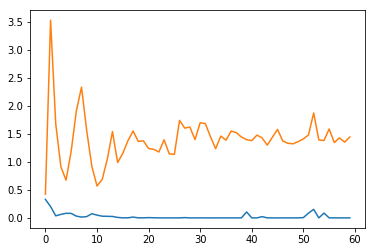

In [ ]:
plt.plot(np.arange(num_epochs), train_loss_row, np.arange(num_epochs), val_loss_row)

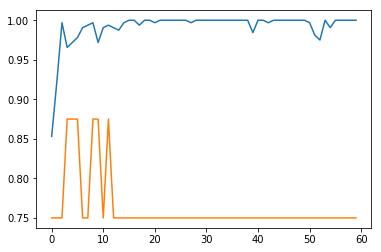

In [ ]:
plt.plot(np.arange(num_epochs), train_acc_row, np.arange(num_epochs), val_acc_row)

## Using of trained model

In [ ]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

FileExistsError: [Errno 17] File exists: 'test/unknown'

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:06<00:00, 14.73it/s]


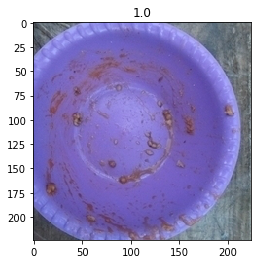

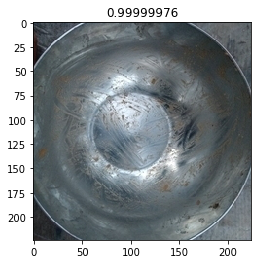

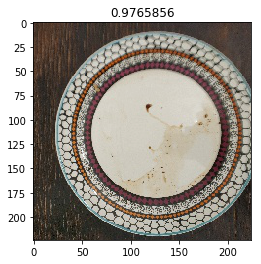

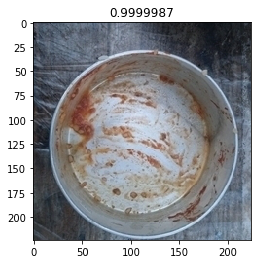

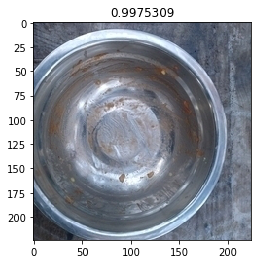

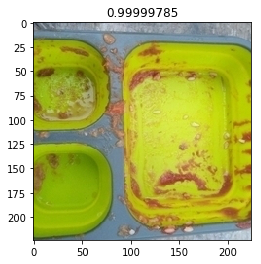

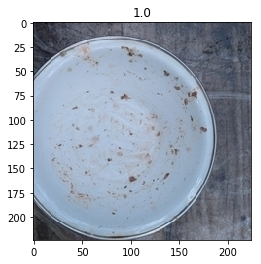

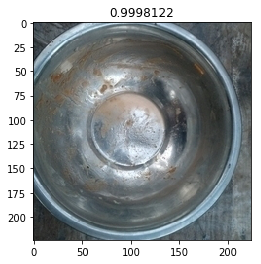

In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

You should check and change board level before you can use your Net. It's value should be near mean value. 

In [ ]:
submission_df['label'].mean()

0.7298662662506104

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.75 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [ ]:
submission_df

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty
0006,dirty
0007,dirty
0008,dirty


In [ ]:
submission_df.to_csv('submission.csv')

In [ ]:
!rm -rf train val test